# Object Detection Using SSD-Mobilenet

## What is SSD?

SSD is an Algorithm used for object Detection in Realtime.Now lets see why SSD is used in Realtime and why it is Better than Other Famous Algorithms

***

### SSD Composes of Two Parts:
1.Extracting Feature Map

2.Apply Convolutional Filter to detect Object

In simple Terms in first part it will extract the features present in the image and in second part it will goona detect the object present in the image.

SSD is an Single Convoutional Neural Network which will do all this process in one go which increases its speed and minimize the unnecessary(For realtime purpose) computations.

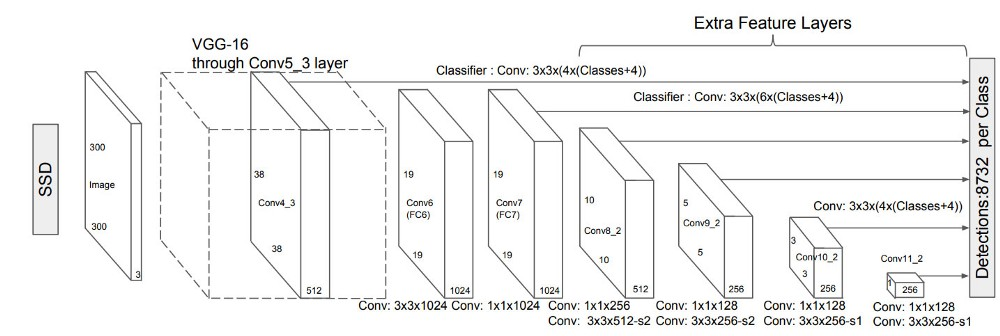
                                    source https://arxiv.org/pdf/1512.02325.pdf
                                    
Here is an Picture Showing VGG-16 which is used as an standard by Inventors of SSD.

***

## But How SSD is Faster than Other Algorithms?

If you know a bit about fast-RCNN and Faster-RCNN then you may know that they are using regional proportion to create the boundary box and use it to classify object. Here they are using multiple CNN to do this which increases the accuracy but on the other hand it also increase Computational cost.

On the other hand SSD completely uses the different appraoch and it does not need to use this the regional proportion and this cost is completely removed.

## But what about Yolo Algorithm?

Yolo algorithm runs the whole network in every grid so according to my experiance it reduces the speed while in SSD it directly run the network on the extracted feature map which is much more convenient.

I Hope You hgot the point which I am tried to convey.

For More Information on SSD Visit https://medium.com/@jonathan_hui/ssd-object-detection-single-shot-multibox-detector-for-real-time-processing-9bd8deac0e06

So I used SSD for my project.

***

## Why I Used Mobile-Net?

Mobile net is the most suited Convolutional Neural Network For Edge Devices like mobile and Ardino.

Mobilenet used depthwise seperable convolutions which consists of two types of convolutional techniques
1. Depthwise Convolution

2. Pointwise Convolution




Lets see how the computational cost is reduced first lets calculate computational cost of standard Convolution.

There are N kernals of size $D_k * D_k$ each kernal computes the entire input which is $D_f * D_f * M$ sized feature map.

Then the computational cost is 
$$
D_g * D_g * M * N * D_k * D_k
$$

Let $D_g * D_g$ be the size of the output feature map. Then a standard convolution takes in a $D_f * D_f * M$ input feature map and returns a $D_g * D_g * N$ feature map as output.

![Standard Convolution](assets/standard_conv.png)




### Depthwise Convolution

In depthwise convolution for each input channel there is different kernal i.e for $M$ input channels there are $M$ Kernals which implies there are $M$ $D_k * D_k$ kernels.

Now computational Cost is 
$$
D_g * D_g * M * D_k * D_k
$$


### Pointwise Convolution

A pointwise convolution performs a 1x1 convolution, it's the same as a Standard convolution except the kernel size is $1 * 1$.

Computation cost:

$$
D_k * D_k * D_g * D_g * M * N =
1 * 1 * D_g * D_g * M * N =
D_g * D_g * M * N
$$

![Pointwise Convolution](assets/pointwise_conv.png)


Thus the total computation cost is for separable depthwise convolution:

$$
D_g * D_g * M * D_k * D_k + D_g * D_g * M * N
$$

which results in $\frac{1}{N} + \frac{1}{D_k^2}$ reduction in computation:

$$
\frac {D_g * D_g * M * D_k * D_k + D_g * D_g * M * N} {D_g * D_g * M * N * D_k * D_k} = 
\frac {D_k^2 + N} {D_k^2*N} = 
\frac {1}{N} + \frac{1}{D_k^2}
$$



### Width Multiplier

The 2nd technique for reducing the computational cost is the "width multiplier" which is a hyperparameter inhabiting the range [0, 1] denoted here as $\alpha$. $\alpha$ reduces the number of input and output channels proportionally:

$$
D_f * D_f * \alpha M * D_k * D_k + D_f * D_f * \alpha M * \alpha N
$$

### Resolution Multiplier

The 3rd technique for reducing the computational cost is the "resolution multiplier" which is a hyperparameter inhabiting the range [0, 1] denoted here as $\rho$. $\rho$ reduces the size of the input feature map:

$$
\rho D_f * \rho D_f * M * D_k * D_k + \rho D_f * \rho D_f * M * N
$$

Combining the width and resolution multipliers results in a computational cost of:

$$
\rho D_f * \rho D_f * a M * D_k * D_k + \rho D_f * \rho D_f * a M * a N
$$

### Here is an Mobile net Model Implemenation in Tensorflow 2

In [1]:
from tensorflow.keras.layers import Input, DepthwiseConv2D,Conv2D,BatchNormalization,ReLU,AvgPool2D,Flatten,Dense

**Creating Mobilenet BLock in which depthiseConv->BN->Relu followed by Conv2->BN->Relu**

In [2]:
def mobilenet_block(x,filters,strides):
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(filters=filters, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

In [3]:
INPUT_SHAPE = 224, 244, 3

input = Input(INPUT_SHAPE)
x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(input)
x = BatchNormalization()(x)
x = ReLU()(x)

x = mobilenet_block(x, filters=64, strides=1)

x = mobilenet_block(x, filters=128, strides=2)
x = mobilenet_block(x, filters=128, strides=1)

x = mobilenet_block(x, filters=256, strides=2)
x = mobilenet_block(x, filters=256, strides=1)

x = mobilenet_block(x, filters=512, strides=2)
for _ in range(5):
    x = mobilenet_block(x, filters=512, strides=1)
  
x = mobilenet_block(x, filters=1024, strides=2)
x = mobilenet_block(x, filters=1024, strides=1)

x = AvgPool2D(pool_size=7, strides=1)(x)
output = Dense(units=1000, activation='softmax')(x)

from tensorflow.keras import Model

model = Model(inputs=input, outputs=output)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 244, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 122, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 122, 32)      128       
_________________________________________________________________
re_lu (ReLU)                 (None, 112, 122, 32)      0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 112, 122, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 122, 32)      128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 112, 122, 32)     

**For this Project I am not making everything from scratch i.e I am using the Pretrained Object detection model from Tensorflow  model zoo**

In [3]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
#import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from imutils.video import VideoStream
from imutils.video import FPS 
import cv2
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
%matplotlib inline


In [5]:
from utils import label_map_util

from utils import visualization_utils as vis_util

In [6]:
PATH_TO_CKPT = 'assets/frozen_inference_graph.pb'
PATH_TO_LABELS = 'assets/mscoco_label_map.pbtxt'

In [7]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [8]:
NUM_CLASSES = 90
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [9]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [10]:
PATH_TO_TEST_IMAGES_DIR = 'assets'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 4) ]
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [11]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                tensor_dict['detection_masks'] = tf.expand_dims(
                detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

## Test On Image

In [12]:
def detectImage(img):
    image = Image.open(img)
    image_np = load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          output_dict['detection_boxes'],
          output_dict['detection_classes'],
          output_dict['detection_scores'],
          category_index,
          instance_masks=output_dict.get('detection_masks'),
          use_normalized_coordinates=True,
          line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    cv2.imshow("image",image_np)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    

In [13]:
detectImage('test-images\image5.jpeg')

In [14]:
TEST_IMAGE_PATHS = 'test-images'
TEST_IMAGE_PATHS = [ os.path.join(TEST_IMAGE_PATHS, 'image{}.jpg'.format(i)) for i in range(2, 3) ]


In [15]:
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
    plt.figure(figsize=(12, 8))
    plt.imshow(image)

In [16]:
imgpath = 'test-images\image5.jpeg'
detectImage(imgpath)

# Test On Video

In [ ]:
cap = cv2.VideoCapture('assets/videoplayback.mp4')  #for video
#cap = cv2.VideoCapture(0) #for realtime
fps = FPS().start()
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        while True:
            ret, image_np = cap.read()
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            (boxes, scores, classes, num_detections) = sess.run([boxes, scores, classes, num_detections],feed_dict={image_tensor: image_np_expanded})
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=8)
            
            # Warning Portion
            for i,b in enumerate(boxes[0]):
                if classes[0][i] == 3 or classes[0][i] == 6 or classes[0][i] == 8:
                    if scores[0][i]>0.5:
                        mid_x = (boxes[0][i][3]+boxes[0][i][1])/2
                        mid_y = (boxes[0][i][2]+boxes[0][i][0])/2
                        apx_distance = round((1-(boxes[0][i][3] - boxes[0][i][1]))**4,1)
                        #cv2.putText(image_np,'{}'.format(apx_distance),(int(mid_x*800),int(mid_y*450)),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),2)
                        if apx_distance<=0.5:
                            if mid_x>0.3 and mid_y<0.7:
                                cv2.putText(image_np,'Warning!!!',(int(mid_x*800),int(mid_y*450)),cv2.FONT_HERSHEY_SIMPLEX,1.0,(0,0,255),3)
                                
            # End
            
            cv2.imshow('object detection', cv2.resize(image_np, (800,450)))
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
            fps.update()
            fps.stop()
            #print("[INFO] elapsed time: {:.2f}".format(fps.elapsed()))
            #print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))
fps.stop()
print("[INFO] elapsed time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))
cv2.destroyAllWindows()
cap.release()